# Скопировано изъ `datagen.ipynb`

In [10]:
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import pi


def normalize(vec):
  return vec / np.linalg.norm(vec)


def random_point_on_a_sphere(n):
  return normalize(np.random.normal(0, 1, n))


def gs(vecs):
  proj = lambda of, on: np.dot(of, on) / np.dot(on, on) * on
  e = []

  for vec in vecs:
    e.append(normalize(vec - np.sum([proj(vec, ej) for ej in e], axis=0)))
  
  return e


def build_onb(vec, eps=1e-6):
  n = len(vec)
  E = [np.array([int(i == j) for j in range(n)]) for i in range(n)]
  E.pop(next(i for i, x in enumerate(vec) if not abs(x) < eps))
  return gs([vec, *E])


def random_elipsoid(n, S, sigma_dist, p):
  sigma = np.diag(sigma_dist(n) ** 2)

  e = np.column_stack(build_onb(random_point_on_a_sphere(n)))
  c = math.sqrt(2 * scipy.special.gammaincinv(n / 2, p))
  l = c * sigma ** 0.5

  X = np.random.multivariate_normal(np.zeros(n), e @ sigma @ e.transpose(), S)

  return X, e, l, np.zeros(n)

In [11]:
# Возвращаетъ коэффиціентъ, на который нужно растянуть пространство для избавленія отъ коллизіи. Значеніе 1 означаетъ, что коллизіи нѣтъ.
def calculate_t_value_for_colision(first_ellipse, second_ellipse):
  e1, l1, c1 = first_ellipse
  e2, l2, c2 = second_ellipse

  # Сферическая коллизія:
  r1 = l1.diagonal().max()
  r2 = l2.diagonal().max()
  t_sphere = (r1 + r2) / np.linalg.norm(c1 - c2)

  if t_sphere <= 1:
    return 1
  
  # TODO: брусовая коллизія
  t_rect = t_sphere

  return min(t_sphere, t_rect)


# TODO: Въ случаѣ съ одномѣрнымъ кластерингомъ, всё ломается при s = [1, 1, 1] и w = [1, 1, 1] по понятнымъ причинамъ
#       Ну, тутъ, собственно, ничего и не сдѣлать... Придётся какъ-то сообщать пользователю объ этомъ экзотическомъ случаѣ, либо
#       вовсѣ не работать съ одномѣрнымъ кластерингомъ, что хуже.
# TODO: probes_cnt долженъ зависеть отъ площади сферы въ n-мѣрномъ пр-вѣ?
def generate_clusters(n, sizes, cluster_weights, d=0.5, p=0.85, probes_cnt=1000):
  sigma_dist=lambda n : np.random.uniform(1 - d, 1 + d, n)

  clusters = []
  N = sum(sizes)
  K = len(sizes)
  alpha = None

  for i in range(K):
    S = sizes[i]
    a = cluster_weights[i]
    X, e, l, _ = random_elipsoid(n, S, sigma_dist, p)

    if i == 0:
      dist = 2 * l.diagonal().max()
      alpha = S * dist ** 2 / a
      c = dist * random_point_on_a_sphere(n)
    
    else:
      dist = math.sqrt(alpha * a / S)

      # Пробированіе
      opt_probe = None

      for _ in range(probes_cnt):
        c = dist * random_point_on_a_sphere(n)

        # Ищемъ t-значенія для пересѣченій
        t = max([calculate_t_value_for_colision((e, l, c), (ei, li, ci)) for _, ei, li, ci in clusters])

        if t <= 1:
          opt_probe = None
          break

        elif opt_probe is None or t < opt_probe[0]:
          opt_probe = (t, c)

      # Процедура rescaling'а:
      if opt_probe is not None:
        t, c = opt_probe
        t *= 1.05 # Домножаемъ на коэффиціентъ для того, чтобы развести кластеры чуть дальше другъ отъ друга
        # print("COLLISION: t = {}".format(t))
        clusters = [(X, e, l, c * t) for X, e, l, c in clusters]
        alpha *= t ** 2
        c *= t

    clusters.append((X, e, l, c))

  return [(X + c, e, l, c) for X, e, l, c in clusters]

# Имлементація алгоритма BANCO:

In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

def iminmax(arr, flag_max):
  m, res = arr[0]

  for el, i in arr:
    if el > m if flag_max else el < m:
      m, res = el, i
  
  return res

def imax(data):
  return iminmax(data, True)

def imin(data):
  return iminmax(data, False)

def extan(vectors, current_vectors_indices, max_it_cnt=10 ** 6):
  ci = imax([(np.linalg.norm(vectors[i]), i) for i in current_vectors_indices])
  c = vectors[ci]
  s = {ci}

  for _ in range(max_it_cnt):
    size = len(s)

    # Примѣняемъ CUR:
    for i in current_vectors_indices:
      vec = vectors[i]

      if i in s and size * np.dot(c, c) > 2 * size * np.dot(c, vec) - np.dot(vec, vec):
        s.remove(i)

      elif i not in s and size * np.dot(c, c) < 2 * size * np.dot(c, vec) + np.dot(vec, vec):
        s.add(i)

    # Обновляемъ c:
    new_c = np.mean(np.array([vectors[i] for i in s]), axis=0)

    # print("[{}] {} -> {} (diff {})".format(len(s), c, new_c, np.linalg.norm(c - new_c)))

    if np.linalg.norm(c - new_c) < 1e-6:
      break

    c = new_c
  
  return s

def banco(vectors, treshhold=0):
  g = np.mean(vectors, axis=0)
  vectors = np.array([v - g for v in vectors])
  current_vectors_indices = {i for i in range(len(vectors))}

  cluster_indices = []

  while len(current_vectors_indices) > 0:
    current_cluster_indices = extan(vectors, current_vectors_indices)
    cluster_indices.append([*current_cluster_indices])
    current_vectors_indices.difference_update(current_cluster_indices)

  # Отбрасываніе малыхъ кластеровъ:
  return [cluster for cluster in cluster_indices if len(cluster) >= treshhold]

# Иплементація алгоритма AGGLOR

In [13]:
def agsu(a):
  clusters = [[i] for i in range(a.shape[0])]

  b = a

  while True:
    m = b.shape[0]

    if m < 3:
      break

    max_ij = None

    for i in range(m):
      for j in range(i + 1, m):
        if b[i, j] >= 0 and (max_ij == None or b[max_ij[0], max_ij[1]] < b[i, j]):
          max_ij = (i, j)

    if max_ij == None:
      break

    # merge
    s, t = max_ij
    for i in range(m):
      b[i][s] += b[i][t]
    for j in range(m):
      b[s][j] += b[t][j]

    clusters[s] = clusters[s] + clusters[t]
    del clusters[t]

    b = np.delete(b, t, 0)
    b = np.delete(b, t, 1)
  
  return b, clusters

def agglor(vectors):
  n = len(vectors)
  a = np.zeros((n, n))

  for i in range(n):
    for j in range(i + 1, n):
      a[i, j] = a[j, i] = math.exp(- np.linalg.norm(vectors[i] - vectors[j]) ** 2)

  whole_sum = np.sum(a)
  row_sum = np.sum(a, axis=0)
  col_sum = np.sum(a, axis=1)

  for i in range(n):
    for j in range(i + 1, n):
      a[i, j] = a[j, i] = a[i, j] - row_sum[i] * col_sum[j] / whole_sum

  _, clusters = agsu(a)
  return clusters

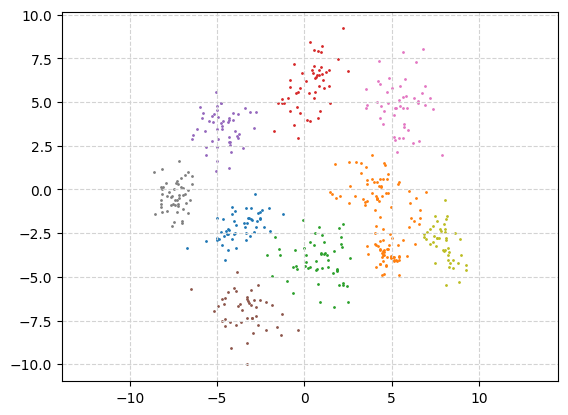

Cluster sizes: [51, 106, 54, 51, 50, 45, 48, 50, 45] (sum = 500)


In [14]:
# Небольшая демонстрація алгоритма AGGLOR:

def simple_draw_clusters(clusters):
  plt.axis('equal')
  plt.grid(color='lightgray', linestyle='--')

  for c in clusters:
    plt.scatter(*np.transpose(c), s=1)
  plt.show()

clusters = generate_clusters(2, [50] * 10, [(i // 3) + 1 for i in range(10)], p=0.8)
vectors = np.array([x for c in clusters for x in c[0]], dtype=object)
gm_ci = agglor(vectors)
simple_draw_clusters(np.array([[vectors[i] for i in s] for s in gm_ci], dtype=object))
print('Cluster sizes: {} (sum = {})'.format([len(c) for c in gm_ci], sum([len(c) for c in gm_ci])))

# Адаптеры алгоритмовъ `k-means` и `EM`

In [15]:
def k_means(vectors, k, init_params, n_init):
  kmeans = KMeans(n_clusters=k, init=init_params, n_init=n_init)
  kmeans.fit(vectors)
  d = {}
  for i, c in enumerate(kmeans.labels_):
    if c in d:
      d[c].append(i)
    else:
      d[c] = []
  return [*d.values()]

In [16]:
def em(vectors, k):
  gm_labels = GaussianMixture(n_components=k).fit_predict(vectors)
  gm_ci = []

  for i in range(len(gm_labels)):
    ind = gm_labels[i]
    while ind >= len(gm_ci):
      gm_ci.append([])
    gm_ci[ind].append(i)
  
  return gm_ci

# Программа для сравненія производительности алгоримтовъ

In [17]:
def calculate_scores(real_clusters, algo_cluster_indices):
  real_labels = [[i] * len(real_clusters[i][0]) for i in range(len(real_clusters))]
  real_labels = [item for sublist in real_labels for item in sublist]

  labels = [-1] * sum([len(c[0]) for c in real_clusters])

  for i in range(len(algo_cluster_indices)):
    for j in algo_cluster_indices[i]:
      labels[j] = i

  return [
    normalized_mutual_info_score(labels, real_labels),
    adjusted_rand_score(labels, real_labels),
    (len(real_clusters) - len(algo_cluster_indices)) / len(real_clusters)
  ]

def experiment(n, k, N, weights, alpha, repetitions):
  sizes = np.random.uniform(1, 2, k)
  sizes = np.ceil(N * sizes / np.sum(sizes)).astype(int)

  scores = []
  for _ in range(repetitions):
    clusters = generate_clusters(n, sizes, weights, p=alpha)
    vectors = np.array([x for c in clusters for x in c[0]])

    banco_ci = banco(vectors, min(sizes) / 50)
    banco_centers = [np.mean([vectors[j] for j in banco_ci[i]], axis=0) for i in range(len(banco_ci))]

    algs = [
      # k_means(vectors, k, 'random', 10),
      k_means(vectors, k, 'k-means++', 1),
      em(vectors, k),
      k_means(vectors, len(banco_ci), banco_centers, 1),
      em(vectors, len(banco_ci)),
      agglor(vectors)
    ]
    scores.append([calculate_scores(clusters, a) for a in algs])

  print('n: {}, k: {}, N: {}, alpha: {} Weights: {}'.format(n, k, N, alpha, weights))
  return np.mean(np.array(scores), axis=0), np.std(np.array(scores), axis=0)

In [18]:
from tabulate import tabulate

def print_table(data):
  m, d = data
  data = [['{:.2f} ± {:.2f}'.format(m[i, j], d[i, j]) for j in range(m.shape[1])] for i in range(m.shape[0])]
  print(tabulate(data, headers=['NMI', 'ARI', 'MARE'], tablefmt="grid", showindex="always"))
  print()


for alpha in [0.5, 0.8]:
  repetitions = 10
  print_table(experiment(10, 7, 1000, [1] * 5 + [3, 7], alpha, repetitions))
  print_table(experiment(10, 7, 1000, [(i + 1) for i in range(7)], alpha, repetitions))
  print_table(experiment(10, 7, 1000, [(i // 3 + 1) for i in range(7)], alpha, repetitions))
  print_table(experiment(10, 15, 1000, [1] * 10 + [3] * 3 + [7] * 2, alpha, repetitions))
  print_table(experiment(10, 15, 1000, [(i + 1) for i in range(15)], alpha, repetitions))
  print_table(experiment(10, 15, 1000, [(i // 3 + 1) for i in range(15)], alpha, repetitions))

n: 10, k: 7, N: 1000, alpha: 0.5 Weights: [1, 1, 1, 1, 1, 3, 7]
+----+-------------+-------------+--------------+
|    | NMI         | ARI         | MARE         |
+====+=============+=============+==============+
|  0 | 0.98 ± 0.02 | 0.97 ± 0.06 | 0.00 ± 0.00  |
+----+-------------+-------------+--------------+
|  1 | 1.00 ± 0.00 | 1.00 ± 0.00 | 0.00 ± 0.00  |
+----+-------------+-------------+--------------+
|  2 | 0.93 ± 0.03 | 0.83 ± 0.08 | 0.13 ± 0.08  |
+----+-------------+-------------+--------------+
|  3 | 0.95 ± 0.03 | 0.87 ± 0.08 | 0.13 ± 0.08  |
+----+-------------+-------------+--------------+
|  4 | 0.90 ± 0.04 | 0.84 ± 0.06 | -2.04 ± 1.01 |
+----+-------------+-------------+--------------+

n: 10, k: 7, N: 1000, alpha: 0.5 Weights: [1, 2, 3, 4, 5, 6, 7]
+----+-------------+-------------+--------------+
|    | NMI         | ARI         | MARE         |
+====+=============+=============+==============+
|  0 | 0.97 ± 0.03 | 0.95 ± 0.08 | 0.00 ± 0.00  |
+----+-------------+-